In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from utils.data_generation import generate_vectors, generate_scalars
from benchmark_functions.sphere import sphere_func
from neural_network_models.feedforward_nn import FeedforwardNN

KeyboardInterrupt: 

## Generating data

In [ ]:
np.random.seed(1000)
torch.manual_seed(1000)

In [ ]:
input_dimention = 4
domain = [-5, 5]

data_set_size = 1_000
training_set_fraction = 0.7
validation_set_fraction = 0.15
test_set_fraction = 0.15

In [ ]:
# generate training data
data_set_vectors = generate_vectors(input_dimention, domain, data_set_size)
data_set_scalars = generate_scalars(data_set_vectors, sphere_func)

# separate training data from validation and test data
training_set_vectors, temp_set_vectors, training_set_scalars, temp_set_scalars = train_test_split(
    data_set_vectors, 
    data_set_scalars, 
    test_size = (validation_set_fraction + test_set_fraction), 
    random_state = 42
)

# separate validation data from test data
validation_set_vectors, test_set_vectors, validation_set_scalars, test_set_scalars = train_test_split(
    temp_set_vectors, 
    temp_set_scalars, 
    test_size = (test_set_fraction / (test_set_fraction + validation_set_fraction)), 
    random_state = 42
)

## Data pre-processing

In [ ]:
vector_scaler = MinMaxScaler().fit(training_set_vectors)
scalar_scaler = StandardScaler().fit(training_set_scalars.reshape(-1, 1))

In [ ]:
training_set_vectors = vector_scaler.transform(training_set_vectors)
validation_set_vectors = vector_scaler.transform(validation_set_vectors)
test_set_vectors = vector_scaler.transform(test_set_vectors)

In [ ]:
training_set_scalars = scalar_scaler.transform(training_set_scalars.reshape(-1, 1))
validation_set_scalars = scalar_scaler.transform(validation_set_scalars.reshape(-1, 1))
test_set_scalars = scalar_scaler.transform(test_set_scalars.reshape(-1, 1))

In [ ]:
# convert generated data to tensors
training_set_vectors = torch.FloatTensor(training_set_vectors)
training_set_scalars = torch.FloatTensor(training_set_scalars)

validation_set_vectors = torch.FloatTensor(validation_set_vectors)
validation_set_scalars = torch.FloatTensor(validation_set_scalars)

test_set_vectors = torch.FloatTensor(test_set_vectors)
test_set_scalars = torch.FloatTensor(test_set_scalars)

## Creating a model

In [ ]:
model = FeedforwardNN(input_neuron_num = input_dimention, h1_neuron_num = 9, output_neuron_num = 1)

loss_func = nn.MSELoss()
loss_optimization_func = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
training_losses = []
validation_losses = []

best_validation_loss = float("inf")
best_model_state = None

tolerance = 1e-4
epoch_limit = 1_200
patience_limit = 15
patience_tries = 0

for epoch in range(epoch_limit):
    # training step
    model.train()

    # pass forward
    training_set_predictions = model(training_set_vectors)
    training_loss = loss_func(training_set_predictions, training_set_scalars)
    training_losses.append(training_loss.item())

    # back-propagation
    loss_optimization_func.zero_grad()
    training_loss.backward()
    loss_optimization_func.step()

    # validation step
    model.eval()

    with torch.no_grad():
        validation_set_predictions = model(validation_set_vectors)
        validation_loss = loss_func(validation_set_predictions, validation_set_scalars)
        validation_losses.append(validation_loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"[{epoch + 1}] Training loss: {training_loss.item():.6f} | Validation loss: {validation_loss.item():.6f}")

    if validation_loss.item() < best_validation_loss - tolerance:
        best_validation_loss = validation_loss.item()
        best_model_state = model.state_dict()
        patience_tries = 0
    else:
        patience_tries += 1
        
        if patience_tries >= patience_limit:
            break

# load best model state
model.load_state_dict(best_model_state)

[50] Training loss: 0.995092 | Validation loss: 0.883919
[100] Training loss: 0.990825 | Validation loss: 0.874093
[150] Training loss: 0.985129 | Validation loss: 0.861296
[200] Training loss: 0.972743 | Validation loss: 0.841730
[250] Training loss: 0.947702 | Validation loss: 0.809847
[300] Training loss: 0.912765 | Validation loss: 0.776447
[350] Training loss: 0.875693 | Validation loss: 0.750548
[400] Training loss: 0.846638 | Validation loss: 0.735587
[450] Training loss: 0.802549 | Validation loss: 0.705104
[500] Training loss: 0.715058 | Validation loss: 0.620243
[550] Training loss: 0.588510 | Validation loss: 0.524437
[600] Training loss: 0.478030 | Validation loss: 0.460533
[650] Training loss: 0.395159 | Validation loss: 0.392421
[700] Training loss: 0.307308 | Validation loss: 0.317099
[750] Training loss: 0.175952 | Validation loss: 0.193927
[800] Training loss: 0.096830 | Validation loss: 0.113371
[850] Training loss: 0.065104 | Validation loss: 0.076547
[900] Training 

<All keys matched successfully>

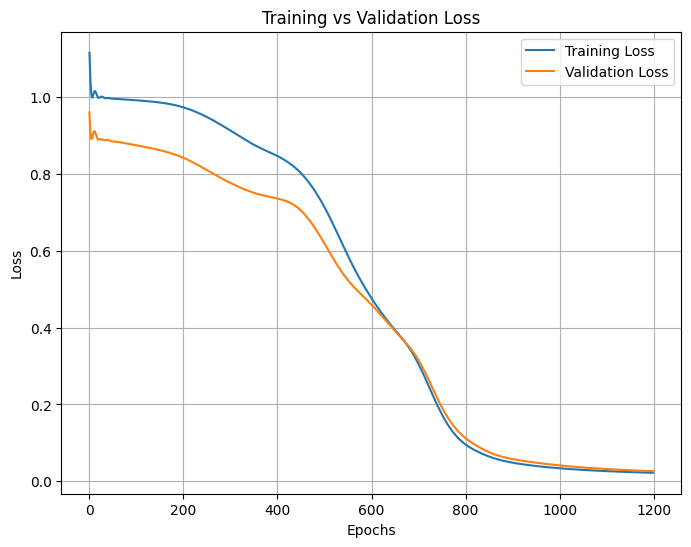

In [ ]:
plt.figure(figsize = (8, 6))

plt.plot(training_losses, label = 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    test_set_predictions = model(test_set_vectors)
    test_loss = loss_func(test_set_predictions, test_set_scalars)
    print("Test loss (MSE): ", test_loss.item())

Test loss (MSE):  0.029054276645183563


In [ ]:
test_set_predictions = test_set_predictions.numpy()
test_set_scalars = test_set_scalars.numpy()

test_set_predictions = scalar_scaler.inverse_transform(test_set_predictions)
test_set_scalars = scalar_scaler.inverse_transform(test_set_scalars)

In [ ]:
absolute_errors = np.abs(test_set_predictions - test_set_scalars)

# min
min_error = np.min(absolute_errors)
print(f"Test set absolute error min: {min_error}")

# max
max_error = np.max(absolute_errors)
print(f"Test set absolute error max: {max_error}")

# mean
error_mean = np.mean(absolute_errors)
print(f"Test set absolute error mean: {error_mean}")

# standard deviation
error_std = np.std(absolute_errors)
print(f"Test set absolute error standard deviation: {error_std}")

Test set absolute error min: 0.007152557373046875
Test set absolute error max: 12.844833374023438
Test set absolute error mean: 2.0209972858428955
Test set absolute error standard deviation: 1.629486083984375
